In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
###Import standard packages###
import numpy as np
from scipy import io
from scipy import stats
import pickle
import hdf5storage
import matplotlib.pyplot as plt
import math

###Import functions for binning data for preprocessing###
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output

In [19]:
data = hdf5storage.loadmat('./data/indy_20160407_02.mat')

neuron_spikes = data['spikes']
neuron_spikes = neuron_spikes.reshape(-1)

cursor_pos = data['cursor_pos']
target_pos = data['target_pos']
reg_times = data['t'].reshape(-1)

In [20]:
vels = np.zeros_like(cursor_pos)

for i in range(1, len(reg_times)):
    c_p_t0 = cursor_pos[i-1]
    c_p_t1 = cursor_pos[i]
    interval = reg_times[i] - reg_times[i-1]
    
    if i == len(reg_times) - 1:
        vels[i] = (c_p_t1 - c_p_t0) / interval
    else:
        c_p_t2 = cursor_pos[i+1]
        vels[i] = ((c_p_t2+c_p_t1) / 2 - (c_p_t1+c_p_t0) / 2) / interval

In [21]:
spike_times=neuron_spikes #Load spike times of all neurons
vel_times=reg_times #Load times at which velocities were recorded


dt=.05 #Size of time bins (in seconds)
t_start=vel_times[0] #Time to start extracting data - here the first time velocity was recorded
t_end=vel_times[-1] #Time to finish extracting data - here the last time velocity was recorded
downsample_factor=1 #Downsampling of output (to make binning go faster). 1 means no downsampling.

#When loading the Matlab cell "spike_times", Python puts it in a format with an extra unnecessary dimension
#First, we will put spike_times in a cleaner format: an array of arrays
spike_times=np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]=np.squeeze(spike_times[i])


###Preprocessing to put spikes and output in bins###

#Bin neural data using "bin_spikes" function
neural_data=bin_spikes(spike_times,dt,t_start,t_end)

#Bin output (velocity) data using "bin_output" function
vels_binned=bin_output(vels,vel_times,dt,t_start,t_end,downsample_factor)

In [6]:
lag=0 #What time bin of spikes should be used relative to the output

#The covariate is simply the matrix of firing rates for all neurons over time
X_kf=neural_data

In [7]:
#For the Kalman filter, we use the position, velocity, and acceleration as outputs
#Ultimately, we are only concerned with the goodness of fit of velocity (for this dataset)
#But using them all as covariates helps performance

#We will now determine position


pos_binned = bin_output(cursor_pos, reg_times, dt, t_start, t_end, downsample_factor)
pos_binned -= pos_binned[0, :]

#We will now determine acceleration    
temp=np.diff(vels_binned,axis=0) #The acceleration is the difference in velocities across time bins 
acc_binned=np.concatenate((temp,temp[-1:,:]),axis=0) #Assume acceleration at last time point is same as 2nd to last

## Kalman Filter

**********************************************************
position
R2: [0.3980324 0.4097306]
rho2: [0.41204405 0.42097284]
**********************************************************
velocity
R2: [0.37928834 0.52548923]
rho2: [0.43145571 0.54858811]
**********************************************************
acceleration
R2: [0.01480205 0.0560366 ]
rho2: [0.08077583 0.10535649]
**********************************************************
position_velocity
R2: [0.61468561 0.59704298 0.4745318  0.56014257]
rho2: [0.63682351 0.66549123 0.48612635 0.57407297]
**********************************************************
position_velocity_acceleration
R2: [0.63622851 0.63578604 0.50011782 0.57177659 0.16773435 0.16637567]
rho2: [0.65747339 0.69344191 0.53825471 0.60720151 0.17790472 0.18238106]


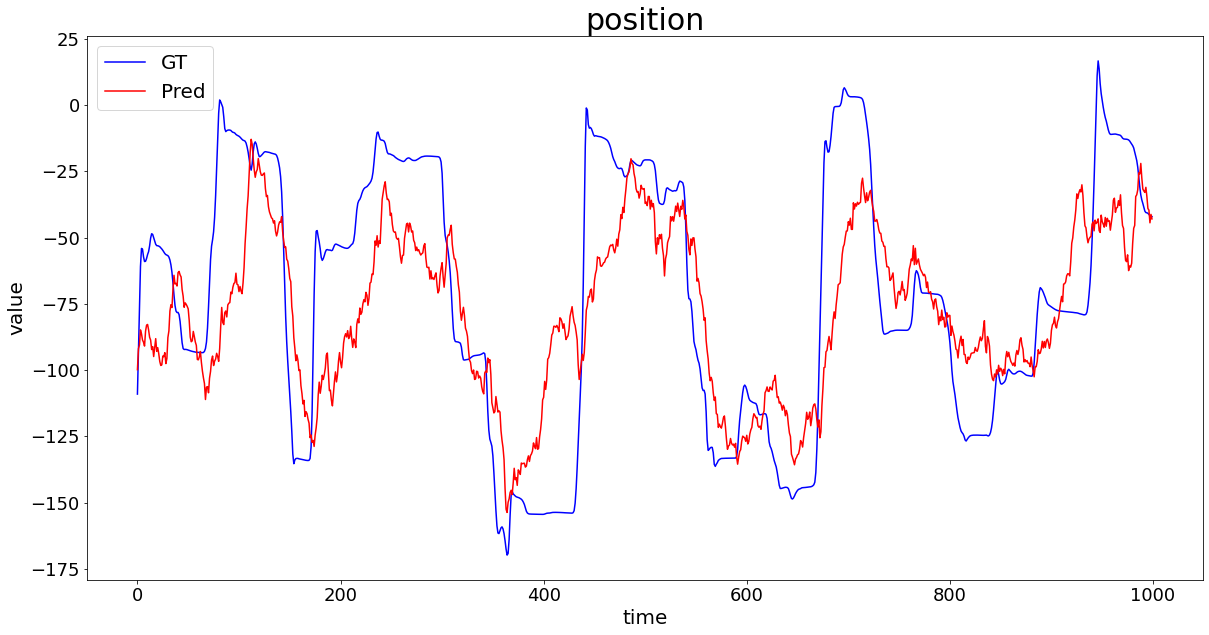

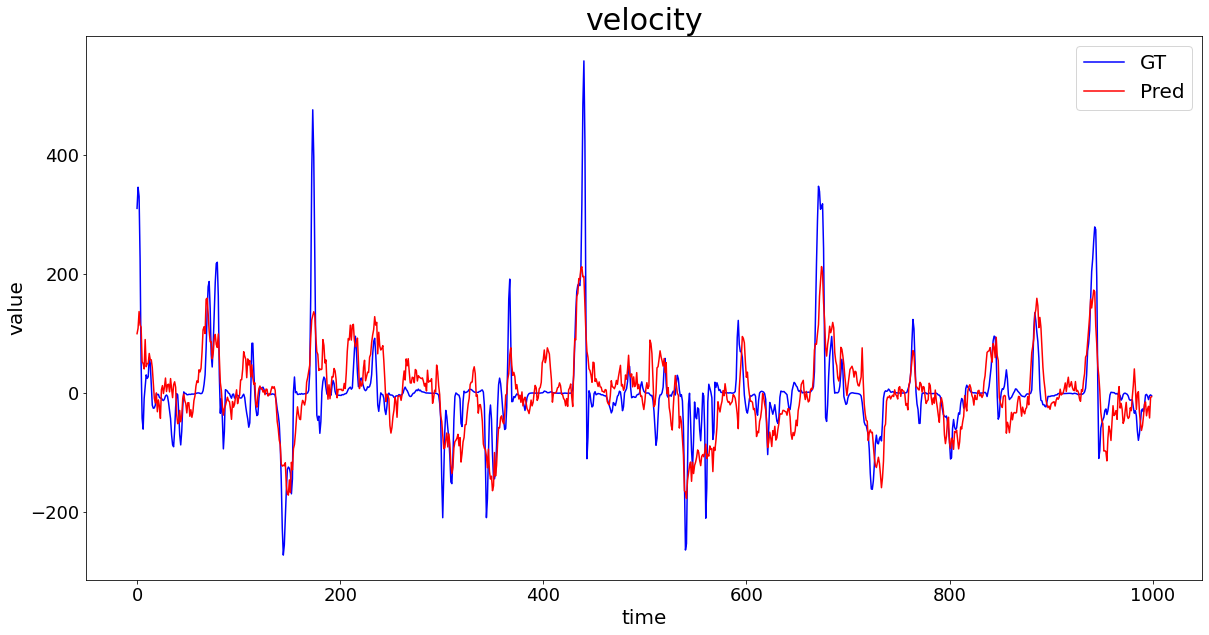

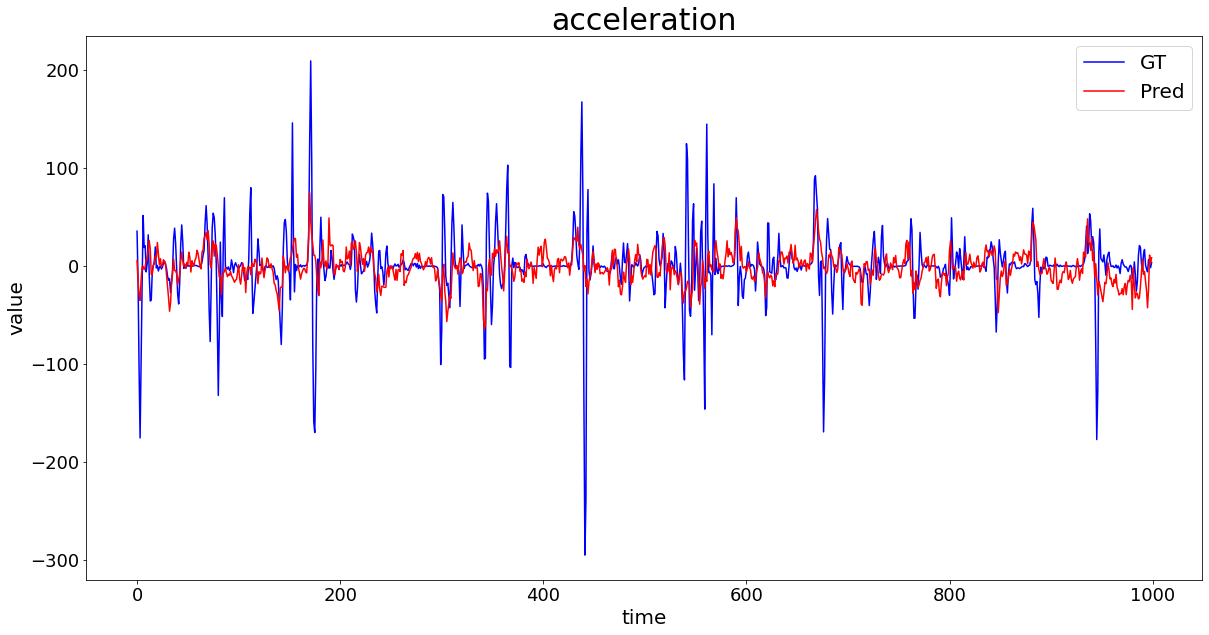

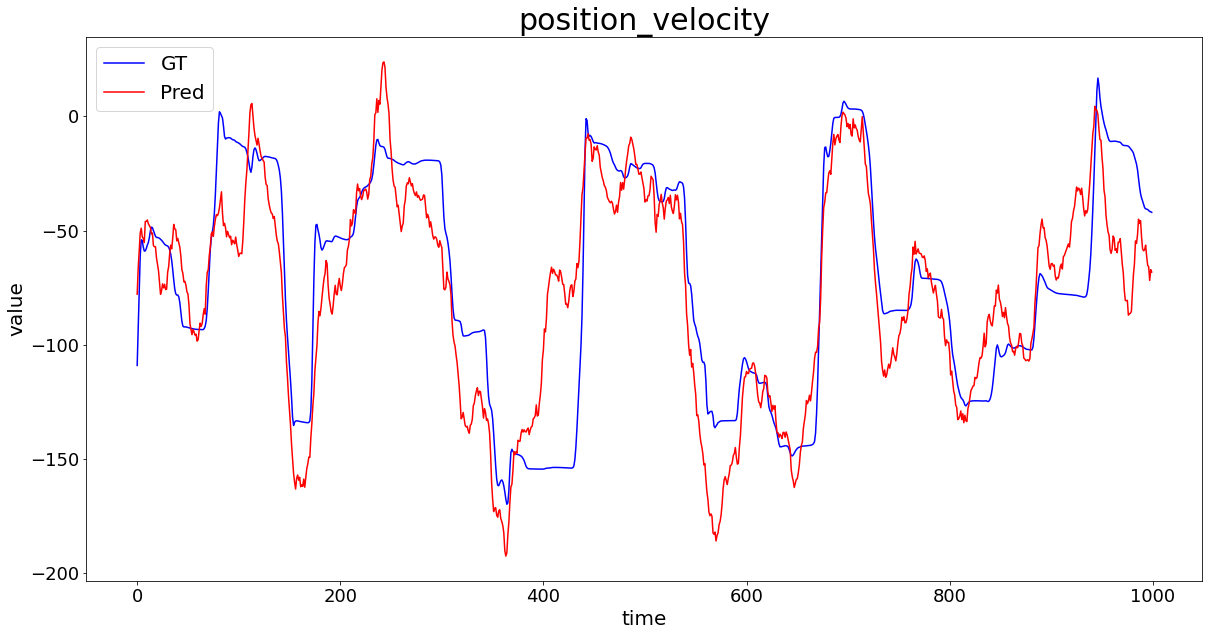

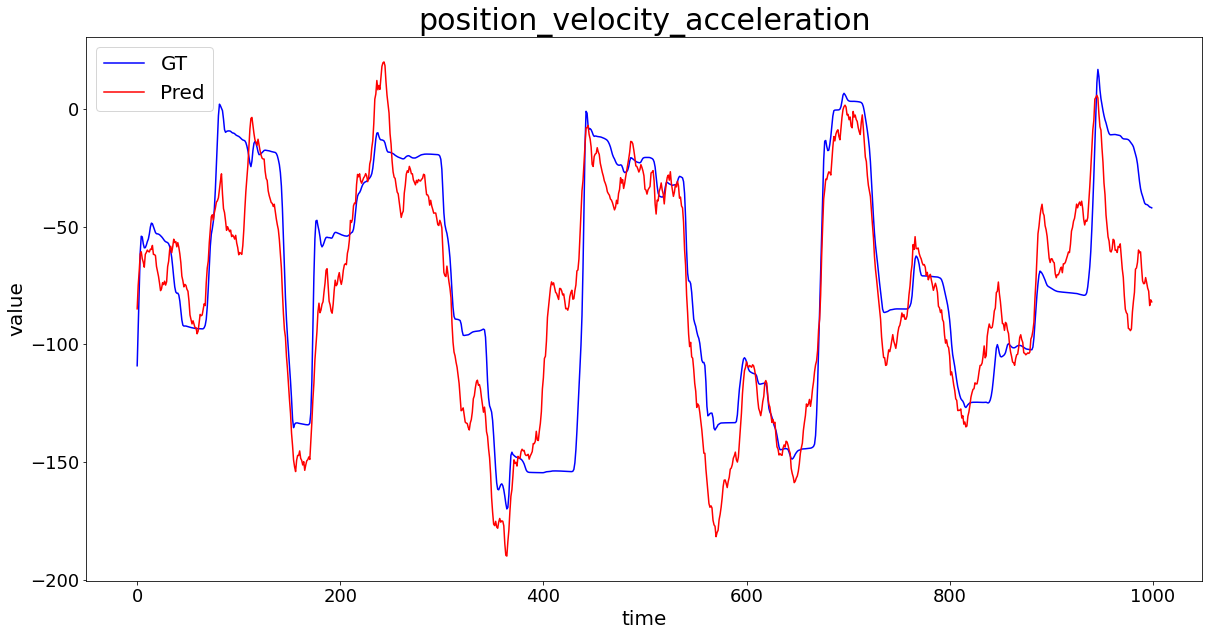

In [8]:
#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import KalmanFilterDecoder


types = ["p", "v", "a", "pv", "pva"]

for t in types:

    variables = []

    title = []

    if "p" in t:
        variables.append(pos_binned)
        title.append("position")
    
    if "v" in t:
        variables.append(vels_binned)
        title.append("velocity")

    if "a" in t:
        variables.append(acc_binned)
        title.append("acceleration")

    title = '_'.join(title)

    print("**********************************************************")
    print(title)

    y_kf=np.concatenate(variables,axis=1)

    num_examples=X_kf.shape[0]

    #Re-align data to take lag into account
    if lag<0:
        y_kf=y_kf[-lag:,:]
        X_kf=X_kf[0:num_examples+lag,:]
    if lag>0:
        y_kf=y_kf[0:num_examples-lag,:]
        X_kf=X_kf[lag:num_examples,:]


    #Set what part of data should be part of the training/testing/validation sets
    training_range=[0, 0.7]
    testing_range=[0.7, 0.85]
    valid_range=[0.85,1]


    #Number of examples after taking into account bins removed for lag alignment
    num_examples_kf=X_kf.shape[0]
            
    #Note that each range has a buffer of 1 bin at the beginning and end
    #This makes it so that the different sets don't include overlapping data
    training_set=np.arange(np.int32(np.round(training_range[0]*num_examples_kf))+1,np.int32(np.round(training_range[1]*num_examples_kf))-1)
    testing_set=np.arange(np.int32(np.round(testing_range[0]*num_examples_kf))+1,np.int32(np.round(testing_range[1]*num_examples_kf))-1)
    valid_set=np.arange(np.int32(np.round(valid_range[0]*num_examples_kf))+1,np.int32(np.round(valid_range[1]*num_examples_kf))-1)

    #Get training data
    X_kf_train=X_kf[training_set,:]
    y_kf_train=y_kf[training_set,:]

    #Get testing data
    X_kf_test=X_kf[testing_set,:]
    y_kf_test=y_kf[testing_set,:]

    #Get validation data
    X_kf_valid=X_kf[valid_set,:]
    y_kf_valid=y_kf[valid_set,:]

    #Z-score inputs 
    X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
    X_kf_train_std=np.nanstd(X_kf_train,axis=0)

    eps = 1e-12
    X_kf_train=(X_kf_train-X_kf_train_mean)/(X_kf_train_std+eps)
    X_kf_test=(X_kf_test-X_kf_train_mean)/(X_kf_train_std+eps)
    X_kf_valid=(X_kf_valid-X_kf_train_mean)/(X_kf_train_std+eps)

    #Zero-center outputs
    y_kf_train_mean=np.mean(y_kf_train,axis=0)
    y_kf_train=y_kf_train-y_kf_train_mean
    y_kf_test=y_kf_test-y_kf_train_mean
    y_kf_valid=y_kf_valid-y_kf_train_mean

    # Kalman Filter

    #Declare model
    model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter that is set to the default in this example (see ReadMe)

    #Fit model
    model_kf.fit(X_kf_train,y_kf_train)

    #Get predictions
    y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

    #Get metrics of fit (see read me for more details on the differences between metrics)

    R2_kf=get_R2(y_kf_valid,y_valid_predicted_kf)
    print('R2:',R2_kf) #I'm just printing the R^2's of the 3rd and 4th entries that correspond to the velocities

    rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
    print('rho2:',rho_kf**2) #I'm just printing the rho^2's of the 3rd and 4th entries that correspond to the velocities


    test_dim = 0

    plt.figure(figsize=(20, 10))

    gt, = plt.plot(y_kf_valid[1000:2000,test_dim]+y_kf_train_mean[test_dim],'b')
    pred, = plt.plot(y_valid_predicted_kf[1000:2000,test_dim]+y_kf_train_mean[test_dim],'r')

    plt.ylabel('value', size=20)
    plt.xlabel('time', size=20)
    plt.tick_params(labelsize=18)

    plt.legend(handles=[gt, pred], labels=['GT', 'Pred'], prop = {'size':20})

    plt.title(title, size=30)

    plt.savefig(f'./imgs/kf/{title}.jpg')


## LSTM

In [9]:
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Neural_Decoding.decoders import LSTMDecoder

In [22]:
bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=6 #How many bins of neural data after the output are used for decoding


# Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

# Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#Set decoding output
y=vels_binned

In [23]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]


num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int32(np.round(training_range[0]*num_examples))+bins_before,np.int32(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int32(np.round(testing_range[0]*num_examples))+bins_before,np.int32(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int32(np.round(valid_range[0]*num_examples))+bins_before,np.int32(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

eps = 1e-12

#Z-score "X" inputs. 
X_train_mean=np.nanmean(X_train,axis=0)
X_train_std=np.nanstd(X_train,axis=0)
X_train=(X_train-X_train_mean)/(X_train_std+eps)
X_test=(X_test-X_train_mean)/(X_train_std+eps)
X_valid=(X_valid-X_train_mean)/(X_train_std+eps)

#Z-score "X_flat" inputs. 
X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
X_flat_train_std=np.nanstd(X_flat_train,axis=0)
X_flat_train=(X_flat_train-X_flat_train_mean)/(X_flat_train_std+eps)
X_flat_test=(X_flat_test-X_flat_train_mean)/(X_flat_train_std+eps)
X_flat_valid=(X_flat_valid-X_flat_train_mean)/(X_flat_train_std+eps)

#Zero-center outputs
y_train_mean=np.mean(y_train,axis=0)
y_train=y_train-y_train_mean
y_test=y_test-y_train_mean
y_valid=y_valid-y_train_mean

In [24]:
#Declare model
model_lstm=LSTMDecoder(units=400,dropout=0,num_epochs=5)

#Fit model
model_lstm.fit(X_train,y_train)

#Get predictions
y_valid_predicted_lstm=model_lstm.predict(X_valid)

#Get metric of fit
R2s_lstm=get_R2(y_valid,y_valid_predicted_lstm)
print('R2s:', R2s_lstm)

2023-11-10 16:58:32.606947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2023-11-10 16:58:32.607762: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-10 16:58:32.608568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vispstar): /proc/driver/nvidia/version does not exist
2023-11-10 16:58:32.614534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 16:58:33.416659: W tensorflow/core/framework/cpu_allocator_impl.c

77/77 [==============================] - 3s 32ms/step
R2s: [0.63940662 0.63146766]


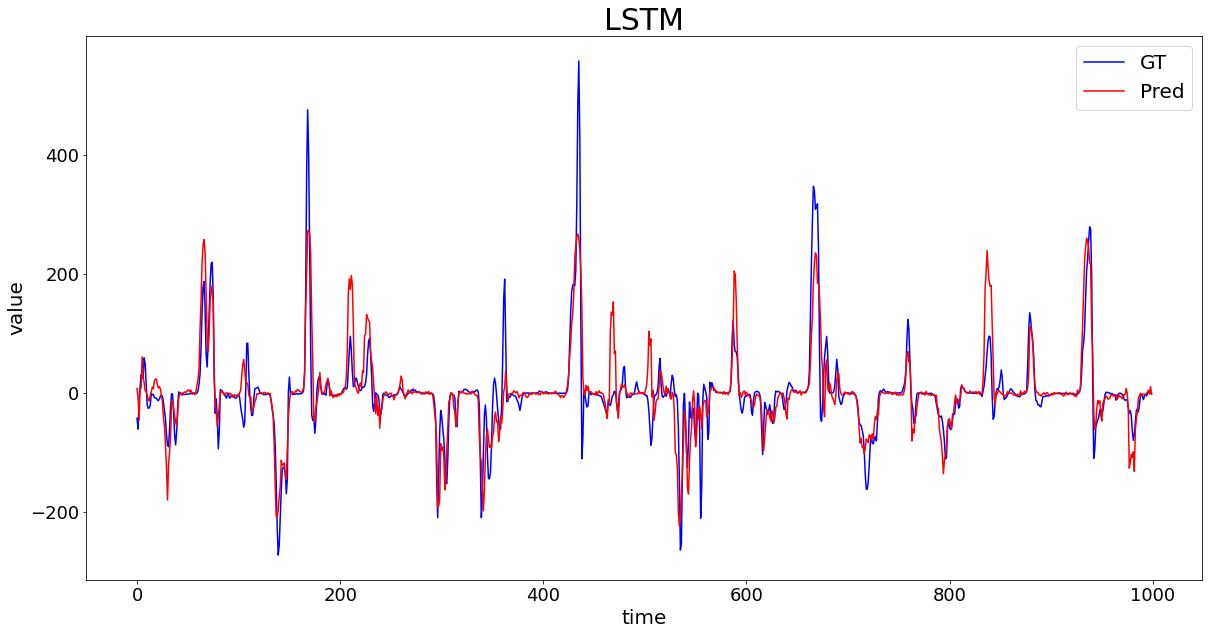

In [26]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_wf=plt.figure(figsize=(20, 10))

plt.ylabel('value', size=20)
plt.xlabel('time', size=20)
plt.tick_params(labelsize=18)

plt.title("LSTM", size=30)

gt,=plt.plot(y_valid[1000:2000,0]+y_train_mean[0],'b')
pred,=plt.plot(y_valid_predicted_lstm[1000:2000,0]+y_train_mean[0],'r')

plt.legend(handles=[gt, pred], labels=['GT', 'Pred'], prop = {'size':20})
plt.savefig(f'./imgs/LSTM.jpg')